In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import obonet
import networkx as nx
import math

# Utilities

## RNA PBPA

In [15]:
def PBPA(RNA_i, RNA_j, di_sim, rna_di):
    diseaseSet_i = rna_di[RNA_i] > 0
    diseaseSet_j = rna_di[RNA_j] > 0
    diseaseSim_ij = di_sim[diseaseSet_i][:, diseaseSet_j]
    ijshape = diseaseSim_ij.shape
    if ijshape[0] == 0 or ijshape[1] == 0:
        return 0
    return (sum(np.max(diseaseSim_ij, axis=0)) + sum(np.max(diseaseSim_ij, axis=1))) / (ijshape[0] + ijshape[1])

In [16]:
def getRNASiNet(RNAlen, diSiNet, rna_di):
    RNASiNet = np.zeros((RNAlen, RNAlen))
    for i in range(RNAlen):
        for j in range(i + 1, RNAlen):
            RNASiNet[i, j] = RNASiNet[j, i] = PBPA(i, j, diSiNet, rna_di)
    return RNASiNet

## Disease Wang's

In [ ]:
url = 'https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/main/src/ontology/doid.obo'
HDO_Net = obonet.read_obo(url)

In [ ]:
def get_SV(disease, w):
    S = HDO_Net.subgraph(nx.descendants(HDO_Net, disease) | {disease})
    SV = dict()
    shortest_paths = nx.shortest_path(S, source=disease)
    for x in shortest_paths:
        SV[x] = math.pow(w, (len(shortest_paths[x]) - 1))
    return SV

In [ ]:
def get_similarity(d1, d2, w):
    SV1 = get_SV(d1, w)
    SV2 = get_SV(d2, w)
    intersection_value= 0
    for disease in (set(SV1.keys()) & set(SV2.keys())):
        intersection_value = intersection_value + SV1[disease]
        intersection_value = intersection_value + SV2[disease]
    return intersection_value / (sum(SV1.values()) + sum(SV2.values()))

In [ ]:
def getDiSiNet(dilen, diseases, w):
    diSiNet = np.zeros((dilen, dilen))
    for d1 in range(dilen):
        if diseases[d1] in HDO_Net.nodes:
            for d2 in range(d1 + 1, dilen):
                if diseases[d2] in HDO_Net.nodes:
                    diSiNet[d1, d2] = diSiNet[d2, d1] = get_similarity(diseases[d1], diseases[d2], w)
    return diSiNet

## 5 folds

In [ ]:
from sklearn.model_selection import KFold

def folds(posi_len, nega_len, dataset):
    positive_idx = np.array(range(0, posi_len))
    random.shuffle(positive_idx)
    negative_idx = np.array(range(0, nega_len))
    random.shuffle(negative_idx)

    positive5foldsidx = []
    negative5foldsidx = []

    kf = KFold(n_splits=5)
    for train, test in kf.split(positive_idx):
        positive_train_idx = positive_idx[train]
        positive_test_idx = positive_idx[test]
        positive5foldsidx.append({'train': positive_train_idx, 'test': positive_test_idx})
    for train, test in kf.split(negative_idx[0: len(positive_idx)]):
        negative_train_idx =negative_idx[train]
        negative_test_idx = negative_idx[test]
        negative5foldsidx.append({'train': negative_train_idx, 'test': np.array(list(negative_test_idx) + list(negative_idx[len(positive_idx): ]))})

    # np.save('data/ours/' + dataset + '/positive5foldsidx', np.array(positive5foldsidx))
    # np.save('data/ours/' + dataset + '/negative5foldsidx', np.array(negative5foldsidx))

In [14]:
def get_posi_nega_ij(lnclen, dilen, lnc_di):
    positive_ij = []
    negative_ij = []
    for i in range(lnclen):
        for j in range(dilen):
            label = lnc_di[i, j]
            if label == 1:
                positive_ij.append((i, j + lnclen))
            elif label == 0:
                negative_ij.append((i, j + lnclen))
    positive_ij = np.array(positive_ij)
    negative_ij = np.array(negative_ij)
    return positive_ij, negative_ij

## cancatenate

In [ ]:
def cancatenate(lnclen, dilen, milen, lnc_di, lnc_mi, mi_di, lncSiNet, diSiNet, miSiNet):
    A = np.zeros((lnclen + dilen + milen, lnclen + dilen + milen))
    A[: lnclen, lnclen: lnclen + dilen] = lnc_di
    A[lnclen: lnclen + dilen, : lnclen] = lnc_di.T
    A[: lnclen, lnclen + dilen: ] = lnc_mi
    A[lnclen + dilen: , : lnclen] = lnc_mi.T
    A[lnclen: lnclen + dilen, lnclen + dilen: ] = mi_di.T
    A[lnclen + dilen: , lnclen: lnclen + dilen] = mi_di
    A[: lnclen, : lnclen] = lncSiNet
    A[lnclen: lnclen + dilen, lnclen: lnclen + dilen] = diSiNet
    A[lnclen + dilen: , lnclen + dilen: ] = miSiNet
    return A

# Dataset1 Fu's

## read files

In [5]:
lncRNAs = list(pd.read_csv('data/other datasets/Fu/lncRNA.csv', header=None)[0])
miRNAs = list(pd.read_csv('data/other datasets/Fu/miRNA.csv', header=None)[0])
diseases = pd.read_csv('data/other datasets/Fu/Disease.csv', header=None)[0]

lnc_mi = pd.read_csv('data/other datasets/Fu/lncRNA-miRNA.csv', header=None)
lnc_cancer = pd.read_csv('data/other datasets/Fu/lncCancer.csv', header=None)
lnc_di = pd.read_csv('data/other datasets/Fu/lncDisease.csv', header=None)
lnc_di[lnc_cancer == 1] = 1
mi_di = pd.read_csv('data/other datasets/Fu/miRNA-Disease.csv', header=None)

selected = np.sum(lnc_di, axis=0) > 0
diseases = list(diseases[selected])

lnc_di = lnc_di.values[:, selected]
lnc_mi = lnc_mi.values
mi_di = mi_di.values[:, selected]
print(lnc_di.shape, lnc_mi.shape, mi_di.shape)
print(np.sum(lnc_di), np.sum(lnc_mi), np.sum(mi_di))

(240, 412) (240, 495) (495, 412)
2697 1002 13562


In [ ]:
# pd.DataFrame(lnc_di, index=lncRNAs, columns=diseases).to_csv('data/ours/dataset1/lnc_di.csv')
# pd.DataFrame(lnc_mi, index=lncRNAs, columns=miRNAs).to_csv('data/ours/dataset1/lnc_mi.csv')
# pd.DataFrame(mi_di, index=miRNAs, columns=diseases).to_csv('data/ours/dataset1/mi_di.csv')

## Similarity

In [6]:
dilen = len(diseases)
lnclen = len(lncRNAs)
milen = len(miRNAs)

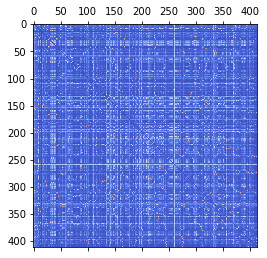

In [ ]:
diSiNet = getDiSiNet(dilen=dilen, diseases=diseases, w=0.5)
plt.matshow(diSiNet, cmap= plt.cm.coolwarm, vmin=0, vmax=1)

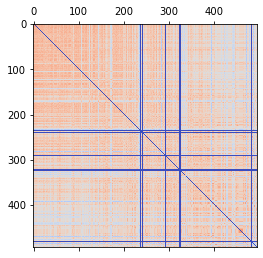

In [ ]:
miSiNet = getRNASiNet(RNAlen=milen, diSiNet=copy.copy(diSiNet), rna_di=copy.copy(mi_di))
plt.matshow(miSiNet, cmap= plt.cm.coolwarm, vmin=0, vmax=1)

## 5 folds

In [21]:
positive_ij, negative_ij = get_posi_nega_ij(lnclen=lnclen, dilen=dilen, lnc_di=lnc_di)
print(positive_ij.shape, negative_ij.shape)

(2697, 2) (96183, 2)


In [22]:
# np.save('data/ours/dataset1/positive_ij.npy', positive_ij)
# np.save('data/ours/dataset1/negative_ij.npy', negative_ij)

In [ ]:
# folds(positive_ij.shape[0], negative_ij.shape[0], 'dataset1') # Run only once

In [ ]:
positive5foldsidx = np.load('data/ours/dataset1/positive5foldsidx.npy', allow_pickle=True)
negative5foldsidx = np.load('data/ours/dataset1/negative5foldsidx.npy', allow_pickle=True)

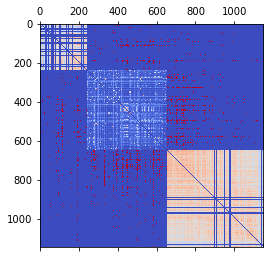

In [ ]:
lncSiNet = getRNASiNet(RNAlen=lnclen, diSiNet=copy.copy(diSiNet), rna_di=copy.copy(lnc_di))

A = cancatenate(lnclen=lnclen, dilen=dilen, milen=milen, lnc_di=lnc_di, lnc_mi=lnc_mi, mi_di=mi_di, lncSiNet=lncSiNet, diSiNet=diSiNet, miSiNet=miSiNet)
plt.matshow(A, cmap= plt.cm.coolwarm, vmin=0, vmax=1)
# plt.savefig('data/ours/dataset1/fig/A.jpg', dpi=1200)
# np.save('data/ours/dataset1/A', A)

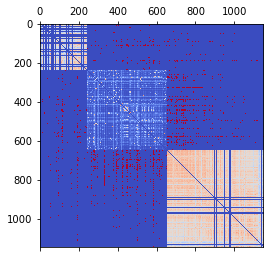

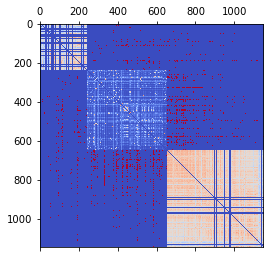

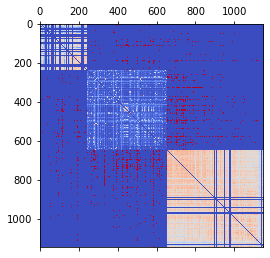

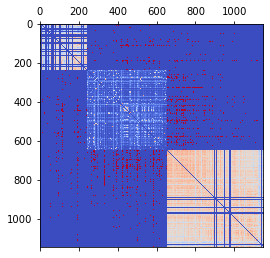

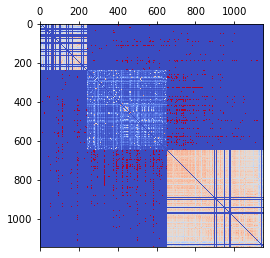

In [ ]:
for fold in range(5):
    lnc_di_copy = copy.copy(lnc_di)
    for ij in positive_ij[positive5foldsidx[fold]['test']]:
        lnc_di_copy[ij[0], ij[1] - lnclen] = 0
    lncSiNet_copy = getRNASiNet(RNAlen=lnclen, diSiNet=copy.copy(diSiNet), rna_di=lnc_di_copy)
    A = cancatenate(lnclen=lnclen, dilen=dilen, milen=milen, lnc_di=lnc_di_copy, lnc_mi=lnc_mi, mi_di=mi_di, lncSiNet=lncSiNet_copy, diSiNet=diSiNet, miSiNet=miSiNet)
    plt.matshow(A, cmap= plt.cm.coolwarm, vmin=0, vmax=1)
    # plt.savefig('data/ours/dataset1/fig/A_' + str(fold) + '.jpg', dpi=1200)
    # np.save('data/ours/dataset1/A_' + str(fold), A)

# Dataset2 ours

## read files

In [9]:
our_di_lnc = pd.read_csv('data/ours/dataset2/intersection/di_lnc_intersection.csv', index_col='Unnamed: 0')
our_di_mi = pd.read_csv('data/ours/dataset2/intersection/di_mi_intersection.csv', index_col='Unnamed: 0')
our_mi_lnc = pd.read_csv('data/ours/dataset2/intersection/mi_lnc_intersection.csv', index_col='Unnamed: 0')

our_diseases = list(our_di_lnc.index)
our_lncRNAs = list(our_di_lnc.columns)
our_miRNAs = list(our_mi_lnc.index)

our_lnc_di = our_di_lnc.values.T
our_mi_di = our_di_mi.values.T
our_lnc_mi = our_mi_lnc.values.T

print(our_lnc_di.shape, our_mi_di.shape, our_lnc_mi.shape)
print(np.sum(our_lnc_di), np.sum(our_mi_di), np.sum(our_lnc_mi))

(665, 316) (295, 316) (665, 295)
3833 8540 2108


## Similarity

In [10]:
our_dilen = len(our_diseases)
our_lnclen = len(our_lncRNAs)
our_milen = len(our_miRNAs)

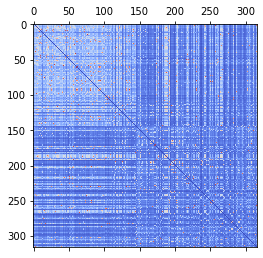

In [ ]:
our_diSiNet = getDiSiNet(dilen=our_dilen, diseases=our_diseases, w=0.8)
plt.matshow(our_diSiNet, cmap = plt.cm.coolwarm, vmin=0, vmax=1)

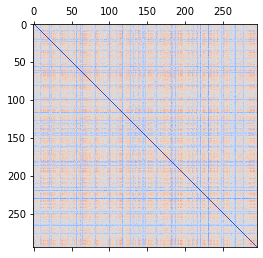

In [ ]:
our_miSiNet = getRNASiNet(RNAlen=our_milen, diSiNet=copy.copy(our_diSiNet), rna_di=copy.copy(our_mi_di))
plt.matshow(our_miSiNet, cmap = plt.cm.coolwarm, vmin=0, vmax=1)

## 5 folds

In [5]:
our_positive_ij, our_negative_ij = get_posi_nega_ij(lnclen=our_lnclen, dilen=our_dilen, lnc_di=our_lnc_di)
print(our_positive_ij.shape, our_negative_ij.shape)

(3833, 2) (206307, 2)


In [6]:
# np.save('data/ours/dataset2/positive_ij.npy', our_positive_ij)
# np.save('data/ours/dataset2/negative_ij.npy', our_negative_ij)

In [ ]:
# folds(our_positive_ij.shape[0], our_negative_ij.shape[0], 'dataset2') # Run only once

In [ ]:
our_positive5foldsidx = np.load('data/ours/dataset2/positive5foldsidx.npy', allow_pickle=True)
our_negative5foldsidx = np.load('data/ours/dataset2/negative5foldsidx.npy', allow_pickle=True)

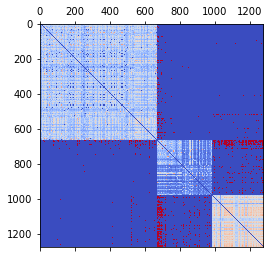

In [ ]:
our_lncSiNet = getRNASiNet(RNAlen=our_lnclen, diSiNet=copy.copy(our_diSiNet), rna_di=our_lnc_di)

A = cancatenate(lnclen=our_lnclen, dilen=our_dilen, milen=our_milen, lnc_di=our_lnc_di, lnc_mi=our_lnc_mi, mi_di=our_mi_di, lncSiNet=our_lncSiNet, diSiNet=our_diSiNet, miSiNet=our_miSiNet)
plt.matshow(A, cmap = plt.cm.coolwarm, vmin=0, vmax=1)
# plt.savefig('data/ours/dataset2/fig/A.jpg', dpi=1200)
# np.save('data/ours/dataset2/A', A)

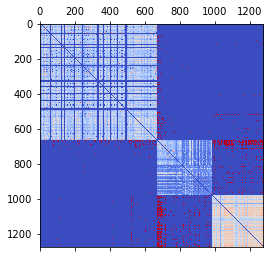

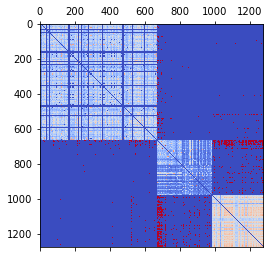

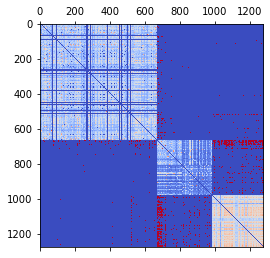

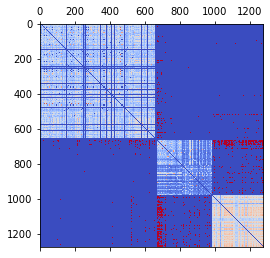

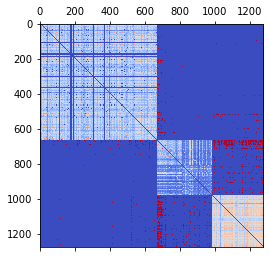

In [ ]:
for fold in range(5):
    our_lnc_di_copy = copy.copy(our_lnc_di)
    for ij in our_positive_ij[our_positive5foldsidx[fold]['test']]:
        our_lnc_di_copy[ij[0], ij[1] - our_lnclen] = 0
    our_lncSiNet_copy = getRNASiNet(RNAlen=our_lnclen, diSiNet=copy.copy(our_diSiNet), rna_di=our_lnc_di_copy)
    A = cancatenate(lnclen=our_lnclen, dilen=our_dilen, milen=our_milen, lnc_di=our_lnc_di_copy, lnc_mi=our_lnc_mi, mi_di=our_mi_di, lncSiNet=our_lncSiNet_copy, diSiNet=our_diSiNet, miSiNet=our_miSiNet)
    plt.matshow(A, cmap = plt.cm.coolwarm, vmin=0, vmax=1)
    # plt.savefig('data/ours/dataset2/fig/A_' + str(fold) + '.jpg', dpi=1200)
    # np.save('data/ours/dataset2/A_' + str(fold), A)